## import library

In [0]:
import numpy as np
import warnings
import pandas as pd
import math
from pandas import read_csv,DataFrame
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error

dataframe = read_csv('house1_min5_KWh.csv',header=None)#hour_data\house5_hour.csv
warnings.filterwarnings("ignore")

## Create dataset as supervised learning problme

In [0]:
def create_dataset(dataset,look_back):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back):
        a=dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX),np.array(dataY)

## Split Train & Test set

In [0]:
def train_test(dataset, look_back):
    dataset=dataset.values
    print(dataset.shape)
    dataset=dataset.astype('float32')
    scaler=StandardScaler(copy=True,with_mean=True,with_std=True)
    dataset=scaler.fit_transform(dataset)
    train,test=dataset[:9000,:],dataset[9000:9120,:]
    #reshape into X=t,Y=t+1,X
    #look_back=12
    trainX,trainY=create_dataset(train,look_back)
    testX,testY=create_dataset(test,look_back)
    print('befor:', trainX.shape)
    #print(len(testY))
    #trainX=np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
    print('after reshape:', trainX.shape)
    #testX=np.reshape(testX,(testX.shape[0],testX.shape[1],1,))
    return trainX, trainY, testX, testY

In [0]:
X_train, y_train, X_test, y_test = train_test(dataframe, look_back=12)

(204780, 1)
befor: (8988, 12)
after reshape: (8988, 12)


# **SVR model**

In [0]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
#param_grid = {"C": np.linspace(10**(-2),10**3,4),
#              'gamma': np.linspace(0.0001,1,3)}

model = SVR(epsilon = 0.1,kernel='rbf', C=1000, gamma=0.0001)
#model = GridSearchCV(estimator = mod, param_grid = param_grid,
#                                   scoring = "neg_mean_squared_error",verbose = 0)

model = model.fit(X_train, y_train.ravel())


In [0]:
def MAPE(predict,true):
    L1=int(true.shape[0])
    L2=int(predict.shape[0])
    #print(L1,   L2)
    if L1==L2:
        #SUM1=sum(abs(true-predict)/abs(true))
        SUM=0.0
        for i in range(L1-1):
            SUM=(abs(true[i]-predict[i+1])/true[i])+SUM
        per_SUM=SUM*100.0
        mape=per_SUM/L1
        return mape
    else:
        print("error")

In [0]:
def plt_result(y_test,predicted_values):
    fig = plt.figure()
    plt.plot(y_test)
    plt.plot(predicted_values[1:])
    plt.xlabel('Time/5min')
    plt.ylabel('Electricity load (kWh)')
    plt.legend(['True', 'Predict'], loc='upper left')
    plt.show()

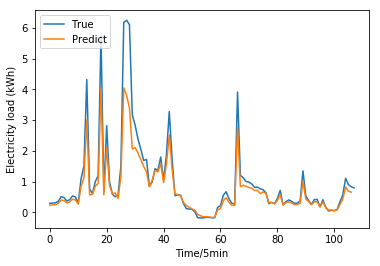

RMSE: 1.0553021677591523
MAPE: 20.90958471570493
MAE: 0.5002554208146767


In [0]:
testPredict = model.predict(X_test)
plt_result(y_test,testPredict )
test_rmse = math.sqrt( mean_squared_error(y_test, testPredict))
test_mae=mean_absolute_error(y_test, testPredict)
mape=MAPE(testPredict,y_test)
print('RMSE:',test_rmse)
print('MAPE:',mape)
print('MAE:',test_mae)

##LSTM model

In [0]:
import numpy as np
import warnings
import pandas as pd
import math
from pandas import read_csv,DataFrame
from keras.models import Sequential
from keras.layers import Dense,LSTM,MaxPooling1D,Dropout,AveragePooling1D
from keras.layers.convolutional import Conv1D
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import time
def LSTM_model(dataset,epoch,look_back=12,LR=0.001):
    dataset=dataset.values
    dataset=dataset.astype('float32')
  
    scaler=StandardScaler(copy=True,with_mean=True,with_std=True)
    dataset=scaler.fit_transform(dataset)
    
    train,test=dataset[:9000,:],dataset[9000:9120,:]
    
    trainX,trainY=create_dataset(train,look_back)
    testX,testY=create_dataset(test,look_back)
    
    trainX=np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
    print(trainX.shape)
    testX=np.reshape(testX,(testX.shape[0],testX.shape[1],1,))

    
    model=Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(12,1)))
    model.add(LSTM(50, activation='relu'))   
    model.add(Dense(activation='linear', units=1))  # output_dim=1, activation='linear'

    # compile the model
    rmsprop = optimizers.RMSprop(LR)
    model.compile(loss="mse", optimizer=rmsprop)
  
    global_start_time = time.time()
    history=model.fit(trainX,trainY,epochs=epoch,batch_size=64,validation_split=0.05,verbose=1)
    print('Training duration (s) : ', time.time() - global_start_time)

    #trainPredict = model.predict(trainX)
    Test_start = time.time()
    testPredict = model.predict(testX)
    print('Testing duration (s) : ', time.time() - Test_start)  
    
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    testY=np.reshape(testY,(-1,1))    
    test_rmse = math.sqrt( mean_squared_error(testY[:,0], testPredict[:, 0]))
    test_mae=mean_absolute_error(testY[:,0], testPredict[:, 0])
   
    mape=MAPE(testPredict,testY)
    return test_rmse,testPredict,testY,history,mape,test_mae

(8988, 12, 1)
Train on 8538 samples, validate on 450 samples
Epoch 1/16
8538/8538 [==============================] - 9s 1ms/step - loss: 0.7668 - val_loss: 0.8196
Epoch 2/16
8538/8538 [==============================] - 6s 645us/step - loss: 0.6198 - val_loss: 3.3794
Epoch 3/16
8538/8538 [==============================] - 5s 640us/step - loss: 0.5425 - val_loss: 0.5880
Epoch 4/16
8538/8538 [==============================] - 5s 635us/step - loss: 0.5077 - val_loss: 0.5414
Epoch 5/16
8538/8538 [==============================] - 5s 638us/step - loss: 0.4866 - val_loss: 0.6097
Epoch 6/16
8538/8538 [==============================] - 5s 635us/step - loss: 0.4857 - val_loss: 0.5534
Epoch 7/16
8538/8538 [==============================] - 6s 644us/step - loss: 0.4803 - val_loss: 0.5547
Epoch 8/16
8538/8538 [==============================] - 5s 643us/step - loss: 0.4778 - val_loss: 0.5459
Epoch 9/16
8538/8538 [==============================] - 6s 683us/step - loss: 0.4759 - val_loss: 0.5286
Epoch

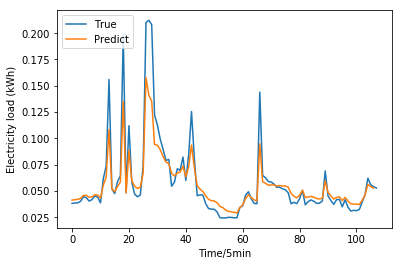

RMSE: 0.02957217882079512
MAPE: [12.477284]
MAE: 0.015023999


In [0]:
np.random.seed(7)
test_rmse, predicted_values, y_test, history, mape,MAE=LSTM_model(dataframe,epoch=16,look_back=12,LR=0.0005)
 
plt_result(y_test,predicted_values)

 
print('RMSE:',test_rmse)
print('MAPE:',mape)
print('MAE:',MAE)

##FC Model

In [0]:
def FC_model(dataset,epoch,look_back=12,LR=0.001):
    trainX, trainY, testX, testY = train_test(dataset, look_back=12)
    
    model=Sequential()
    model.add(Dense(50, activation='relu', input_shape=(12,)))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu')) 
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))   
    model.add(Dropout(0.5))
    model.add(Dense(activation='linear', units=1))  # output_dim=1, activation='linear'
    
    # compile the model
    rmsprop = optimizers.RMSprop(LR)
    model.compile(loss="mse", optimizer=rmsprop)
    print(model.summary())
    global_start_time = time.time()
    history=model.fit(trainX,trainY,epochs=epoch,batch_size=64,validation_split=0.05,verbose=1)
    print('Training duration (s) : ', time.time() - global_start_time)

    #trainPredict = model.predict(trainX)
    Test_start = time.time()
    testPredict = model.predict(testX)
    print('Testing duration (s) : ', time.time() - Test_start)  
    
    test_rmse = math.sqrt( mean_squared_error(testY, testPredict))
    test_mae=mean_absolute_error(testY, testPredict,)
   
    mape=MAPE(testPredict,testY)
    return test_rmse,testPredict,testY,history,mape,test_mae

(204780, 1)
befor: (8988, 12)
after reshape: (8988, 12)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 50)                650       
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 100)               5100      
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_56 (Dense)    

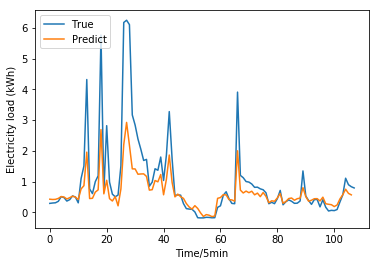

RMSE: 1.124744598219687
MAPE: [53.05751]
MAE: 0.5457191


In [0]:
np.random.seed(7)
test_rmse, predicted_values, y_test, history, mape,MAE=FC_model(dataframe,epoch=16,look_back=12,LR=0.0005)
 
plt_result(y_test,predicted_values)

 
print('RMSE:',test_rmse)
print('MAPE:',mape)
print('MAE:',MAE)

## CNN + LSTM Model

In [5]:
def LSTM_model(dataset,epoch,look_back=12,LR=0.001):
    dataset=dataset.values
    dataset=dataset.astype('float32')
  
    scaler=StandardScaler(copy=True,with_mean=True,with_std=True)
    dataset=scaler.fit_transform(dataset)
    
    train,test=dataset[:9000,:],dataset[9000:9120,:]
    
    trainX,trainY=create_dataset(train,look_back)
    testX,testY=create_dataset(test,look_back)
    
    trainX=np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
    print(trainX.shape)
    testX=np.reshape(testX,(testX.shape[0],testX.shape[1],1,))

    
    model=Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu',input_shape=(None,1)))#,input_shape=(None,1)
    model.add(Conv1D(filters=64,kernel_size=3,padding='valid',activation='relu'))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.1))
    # linear activation: a(x) = x
    model.add(Dense(activation='linear', units=1))
    # compile the model
    rmsprop = optimizers.RMSprop(LR)
    model.compile(loss="mse", optimizer=rmsprop)
  
    global_start_time = time.time()
    history=model.fit(trainX,trainY,epochs=epoch,batch_size=64,validation_split=0.05,verbose=1)
    print('Training duration (s) : ', time.time() - global_start_time)

    #trainPredict = model.predict(trainX)
    Test_start = time.time()
    testPredict = model.predict(testX)
    print('Testing duration (s) : ', time.time() - Test_start)  
    
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    testY=np.reshape(testY,(-1,1))    
    test_rmse = math.sqrt( mean_squared_error(testY[:,0], testPredict[:, 0]))
    test_mae=mean_absolute_error(testY[:,0], testPredict[:, 0])
   
    mape=MAPE(testPredict,testY)
    return test_rmse,testPredict,testY,history,mape,test_mae


Using TensorFlow backend.


W0719 10:16:19.727961 140099979941760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 10:16:19.777613 140099979941760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 10:16:19.786904 140099979941760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



(8988, 12, 1)


W0719 10:16:20.060746 140099979941760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0719 10:16:20.070378 140099979941760 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0719 10:16:20.106277 140099979941760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0719 10:16:20.342875 140099979941760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_

Train on 8538 samples, validate on 450 samples
Epoch 1/16
8538/8538 [==============================] - 9s 1ms/step - loss: 0.5717 - val_loss: 0.5675
Epoch 2/16
8538/8538 [==============================] - 2s 268us/step - loss: 0.4877 - val_loss: 0.5929
Epoch 3/16
8538/8538 [==============================] - 2s 255us/step - loss: 0.4777 - val_loss: 0.5538
Epoch 4/16
8538/8538 [==============================] - 2s 251us/step - loss: 0.4733 - val_loss: 0.5604
Epoch 5/16
8538/8538 [==============================] - 2s 255us/step - loss: 0.4724 - val_loss: 0.5437
Epoch 6/16
8538/8538 [==============================] - 2s 250us/step - loss: 0.4649 - val_loss: 0.5415
Epoch 7/16
8538/8538 [==============================] - 2s 259us/step - loss: 0.4607 - val_loss: 0.5222
Epoch 8/16
8538/8538 [==============================] - 2s 278us/step - loss: 0.4538 - val_loss: 0.5310
Epoch 9/16
8538/8538 [==============================] - 2s 273us/step - loss: 0.4556 - val_loss: 0.4992
Epoch 10/16
8538/85

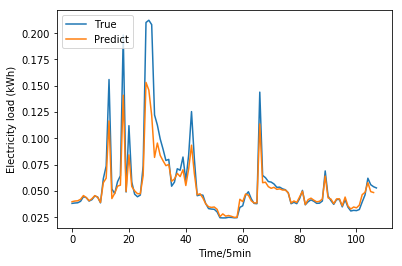

RMSE: 0.030289018182461352
MAPE: [7.956209]
MAE: 0.0140001895


In [8]:
np.random.seed(7)
test_rmse, predicted_values, y_test, history, mape,MAE=LSTM_model(dataframe,epoch=16,look_back=12,LR=0.0005)
 
plt_result(y_test,predicted_values)

 
print('RMSE:',test_rmse)
print('MAPE:',mape)
print('MAE:',MAE)